# Predicting Football Outcomes - COMP0036

Toby Bunn, Francisco Papadopulos, Fidhal Kotta, Mohamed Rammal, Keeley Smyth, Samuel McDougall

## 1. Introduction

In this notebook, data from the English Premier League is used the train various machine learning algorithms to predict the results of games occuring on the 14th of January 2023.

First all of the various libraries needed are imported.

In [1]:
#Standard Python libraries for data and visualisation
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn as sk
import matplotlib.pyplot as plt

#Import models
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, SVR

#Import error metric
from sklearn.metrics import log_loss, confusion_matrix 
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

#Import data munging tools
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


#Import interact from ipywidgets
from ipywidgets import interact
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 2. Data Import

The given data with small changes made is imported.

In [2]:
data = pd.read_csv('epl-trainingNEW.csv')
data

date  Day  Month  Year   Column1       HomeTeam       AwayTeam  \
0     19/08/2000   19      8  2000  0.634409       Charlton       Man City   
1     19/08/2000   19      8  2000  0.634409        Chelsea       West Ham   
2     19/08/2000   19      8  2000  0.634409       Coventry  Middlesbrough   
3     19/08/2000   19      8  2000  0.634409          Derby    Southampton   
4     19/08/2000   19      8  2000  0.634409          Leeds        Everton   
...          ...  ...    ...   ...       ...            ...            ...   
8516  28/12/2022   28     12  2022  0.000000          Leeds       Man City   
8517  30/12/2022   30     12  2022  0.000000       West Ham      Brentford   
8518  30/12/2022   30     12  2022  0.000000      Liverpool      Leicester   
8519  01/01/2023    1      1  2023  0.000000      Tottenham    Aston Villa   
8520  01/01/2023    1      1  2023  0.000000  Nott'm Forest        Chelsea   

      FTHG  FTAG FTR  ...   AC    HF    AF   HY   AY   HR   AR  ScoreH  \
0      4.0   0.0   H  ...  6.0  13.0  12.0  1.0  2.0  0.0  0.0       3   
1      4.0   2.0   H  ...  7.0  19.0  14.0  1.0  2.0  0.0  0.0       3   
2      1.0   3.0   A  ...  4.0  15.0  21.0  5.0  3.0  1.0  0.0       1   
3      2.0   2.0   D  ...  8.0  11.0  13.0  1.0  1.0  0.0  0.0       0   
4      2.0   0.0   H  ...  4.0  21.0  20.0  1.0  3.0  0.0  0.0       3   
...    ...   ...  ..  ...  ...   ...   ...  ...  ...  ...  ...     ...   
8516   1.0   3.0   A  ...  5.0  11.0  14.0  3.0  3.0  0.0  0.0       0   
8517   0.0   2.0   A  ...  1.0   9.0   5.0  1.0  0.0  0.0  0.0       0   
8518   2.0   1.0   H  ...  5.0   8.0  15.0  0.0  1.0  0.0  0.0       3   
8519   0.0   2.0   A  ...  3.0  15.0  10.0  4.0  3.0  0.0  0.0       0   
8520   1.0   1.0   D  ...  2.0  16.0  14.0  2.0  2.0  0.0  0.0       1   

      ScoreA  Count  
0          0      1  
1          0      2  
2          1      3  
3          3      4  
4          0      5  
...      ...    ...  
8516       3   8517  
8517       3   8518  
8518       0   8519  
8519       3   8520  
8520       1   8521  

[8521 rows x 28 columns]

Import epl-test data.

In [3]:
finalTestData = pd.read_csv('epl-test.csv')
finalTestData = finalTestData.drop(columns=["date","Day"])
finalTestData.loc[:,"Year"] = finalTestData["Year"]-2000
finalTestData

Month  Year       HomeTeam        AwayTeam      Referee
0      1    23    Aston Villa           Leeds    J Gillett
1      1    23      Brentford     Bournemouth    S Attwell
2      1    23       Brighton       Liverpool     A Taylor
3      1    23        Chelsea  Crystal Palace    P Tierney
4      1    23        Everton     Southampton   A Marriner
5      1    23     Man United        Man City  M Salisbury
6      1    23      Newcastle          Fulham     S Hooper
7      1    23  Nott'm Forest       Leicester     P Bankes
8      1    23      Tottenham         Arsenal     J Brooks
9      1    23         Wolves        West Ham      R Jones

Import the other additional data found, like budget, managers and league position.

In [67]:
budgetOriginal = pd.read_excel("TeamSpending.xlsx")
managersData = pd.read_excel("Managers.xlsx")
leaguePosData = pd.read_excel("LeaguePosition.xlsx")

## 3. Data Transformation & Exploration


The empty rows are dropped and the Year data is reduced to a range from 0 to 22, instead of 2000 to 2022, performing feature scaling. The list of all the unique teams are found.

Redundant "date" column is removed.

In [4]:
data.loc[:,"Year"] = data["Year"]-2000
data = data.dropna()
data = data.drop(columns=['Column1'])
data = data.drop(columns=['date'])

teams = data["HomeTeam"].drop_duplicates()
teams.sort_values()
data

Day  Month  Year       HomeTeam       AwayTeam  FTHG  FTAG FTR  \
0      19      8     0       Charlton       Man City   4.0   0.0   H   
1      19      8     0        Chelsea       West Ham   4.0   2.0   H   
2      19      8     0       Coventry  Middlesbrough   1.0   3.0   A   
3      19      8     0          Derby    Southampton   2.0   2.0   D   
4      19      8     0          Leeds        Everton   2.0   0.0   H   
...   ...    ...   ...            ...            ...   ...   ...  ..   
8516   28     12    22          Leeds       Man City   1.0   3.0   A   
8517   30     12    22       West Ham      Brentford   0.0   2.0   A   
8518   30     12    22      Liverpool      Leicester   2.0   1.0   H   
8519    1      1    23      Tottenham    Aston Villa   0.0   2.0   A   
8520    1      1    23  Nott'm Forest        Chelsea   1.0   1.0   D   

               Referee    HS  ...   AC    HF    AF   HY   AY   HR   AR  \
0           Rob Harris  17.0  ...  6.0  13.0  12.0  1.0  2.0  0.0  0.0   
1        Graham Barber  17.0  ...  7.0  19.0  14.0  1.0  2.0  0.0  0.0   
2         Barry Knight   6.0  ...  4.0  15.0  21.0  5.0  3.0  1.0  0.0   
3          Andy D'Urso   6.0  ...  8.0  11.0  13.0  1.0  1.0  0.0  0.0   
4     Dermot Gallagher  17.0  ...  4.0  21.0  20.0  1.0  3.0  0.0  0.0   
...                ...   ...  ...  ...   ...   ...  ...  ...  ...  ...   
8516         S Attwell   9.0  ...  5.0  11.0  14.0  3.0  3.0  0.0  0.0   
8517         D England  20.0  ...  1.0   9.0   5.0  1.0  0.0  0.0  0.0   
8518          C Pawson  21.0  ...  5.0   8.0  15.0  0.0  1.0  0.0  0.0   
8519          J Brooks   6.0  ...  3.0  15.0  10.0  4.0  3.0  0.0  0.0   
8520          P Bankes  12.0  ...  2.0  16.0  14.0  2.0  2.0  0.0  0.0   

      ScoreH  ScoreA  Count  
0          3       0      1  
1          3       0      2  
2          1       1      3  
3          0       3      4  
4          3       0      5  
...      ...     ...    ...  
8516       0       3   8517  
8517       0       3   8518  
8518       3       0   8519  
8519       0       3   8520  
8520       1       1   8521  

[8520 rows x 26 columns]

### Additional Data transformation

Budget data has been found per team for every year and this is imported and a rolling mean for the 3 years has been found. Then for each match played in the data, the budget data of the Home and Away team is appended in new columns. 

Finally the budget data is then normalised between -1 and 1.

In [5]:
pd.options.mode.chained_assignment = None

budget = budgetOriginal.rolling(3, min_periods=1).mean()

budget['Team'] = budgetOriginal["Team"]

HT_budget =[]
AT_budget =[]

for match in data[["Month","Year","HomeTeam","AwayTeam"]].values:
    if match[0] < 6:
        HT_budget.append(budget[match[2]].values[match[1]-1])
        AT_budget.append(budget[match[3]].values[match[1]-1])
    else:
        HT_budget.append(budget[match[2]].values[match[1]])
        AT_budget.append(budget[match[3]].values[match[1]])
    
data.loc[:,"HomeBudget"] = HT_budget
data.loc[:,"AwayBudget"] = AT_budget

data.loc[:,"HomeBudget"] = sk.preprocessing.normalize(data["HomeBudget"].to_numpy().reshape(1, -1)).reshape(-1,1)
data.loc[:,"AwayBudget"] = sk.preprocessing.normalize(data["AwayBudget"].to_numpy().reshape(1, -1)).reshape(-1,1)

data[["Day","Month","Year","HomeTeam", "AwayTeam", "HomeBudget", "AwayBudget"]]

Day  Month  Year       HomeTeam       AwayTeam  HomeBudget  AwayBudget
0      19      8     0       Charlton       Man City    0.005967    0.005524
1      19      8     0        Chelsea       West Ham    0.004318   -0.006974
2      19      8     0       Coventry  Middlesbrough   -0.002143    0.006892
3      19      8     0          Derby    Southampton    0.001899    0.000043
4      19      8     0          Leeds        Everton    0.012016   -0.000314
...   ...    ...   ...            ...            ...         ...         ...
8516   28     12    22          Leeds       Man City    0.017470    0.012965
8517   30     12    22       West Ham      Brentford    0.023918    0.008085
8518   30     12    22      Liverpool      Leicester    0.013629    0.000473
8519    1      1    23      Tottenham    Aston Villa    0.028419    0.012666
8520    1      1    23  Nott'm Forest        Chelsea    0.015204    0.040027

[8520 rows x 7 columns]

Repeat for test data.

In [6]:
HT_budgetTEST =[]
AT_budgetTEST =[]

for match in finalTestData[["Month","Year","HomeTeam","AwayTeam"]].values:
    if match[0] < 6:
        HT_budgetTEST.append(budget[match[2]].values[match[1]-1])
        AT_budgetTEST.append(budget[match[3]].values[match[1]-1])
    else:
        HT_budgetTEST.append(budget[match[2]].values[match[1]])
        AT_budgetTEST.append(budget[match[3]].values[match[1]])
    
finalTestData.loc[:,"HomeBudget"] = HT_budgetTEST
finalTestData.loc[:,"AwayBudget"] = AT_budgetTEST

finalTestData.loc[:,"HomeBudget"] = sk.preprocessing.normalize(finalTestData["HomeBudget"].to_numpy().reshape(1, -1)).reshape(-1,1)
finalTestData.loc[:,"AwayBudget"] = sk.preprocessing.normalize(finalTestData["AwayBudget"].to_numpy().reshape(1, -1)).reshape(-1,1)

finalTestData[["Month","Year","HomeTeam", "AwayTeam", "HomeBudget", "AwayBudget"]]

Month  Year       HomeTeam        AwayTeam  HomeBudget  AwayBudget
0      1    23    Aston Villa           Leeds    0.171153    0.355541
1      1    23      Brentford     Bournemouth    0.109252    0.053719
2      1    23       Brighton       Liverpool   -0.076411    0.277379
3      1    23        Chelsea  Crystal Palace    0.540853    0.233985
4      1    23        Everton     Southampton    0.109319    0.148035
5      1    23     Man United        Man City    0.532599    0.264499
6      1    23      Newcastle          Fulham    0.401139    0.155265
7      1    23  Nott'm Forest       Leicester    0.204948    0.009645
8      1    23      Tottenham         Arsenal    0.383085    0.621278
9      1    23         Wolves        West Ham    0.122995    0.486782

Next data on which clubs had which managers has been found and imported. Then for each match played in the data, the manager data of the Home and Away team is appended in new columns.

In [7]:
homeManager = []
awayManager = []

for match in data[["Month", "Year","HomeTeam","AwayTeam"]].values:
    homeManager.append(managersData[(managersData['Year'] == match[1]) & (managersData['Month'] == match[0])][match[2]].iloc[0])
    awayManager.append(managersData[(managersData['Year'] == match[1]) & (managersData['Month'] == match[0])][match[3]].iloc[0])

data.loc[:,"HomeManager"] = homeManager
data.loc[:,"AwayManager"] = awayManager

data[["Day","Month","Year", "HomeTeam", "AwayTeam", "HomeManager", "AwayManager"]]

Day  Month  Year       HomeTeam       AwayTeam      HomeManager  \
0      19      8     0       Charlton       Man City  Alan Curbishley   
1      19      8     0        Chelsea       West Ham  Claudio Ranieri   
2      19      8     0       Coventry  Middlesbrough  Gordon Strachan   
3      19      8     0          Derby    Southampton        Jim Smith   
4      19      8     0          Leeds        Everton    David O'Leary   
...   ...    ...   ...            ...            ...              ...   
8516   28     12    22          Leeds       Man City      Jesse March   
8517   30     12    22       West Ham      Brentford      David Moyes   
8518   30     12    22      Liverpool      Leicester     Jurgen Klopp   
8519    1      1    23      Tottenham    Aston Villa    Antonio Conte   
8520    1      1    23  Nott'm Forest        Chelsea     Steve Cooper   

          AwayManager  
0           Joe Royle  
1      Harry Redknapp  
2        Bryan Robson  
3        Glenn Hoddle  
4        Walter Smith  
...               ...  
8516    Pep Guardiola  
8517     Thomas Frank  
8518  Brendan Rodgers  
8519       Unai Emery  
8520    Graham Potter  

[8520 rows x 7 columns]

Repeat for test data.

In [8]:
homeManagerTEST = []
awayManagerTEST = []

for match in finalTestData[["Month", "Year","HomeTeam","AwayTeam"]].values:
    homeManagerTEST.append(managersData[(managersData['Year'] == match[1]) & (managersData['Month'] == match[0])][match[2]].iloc[0])
    awayManagerTEST.append(managersData[(managersData['Year'] == match[1]) & (managersData['Month'] == match[0])][match[3]].iloc[0])

finalTestData.loc[:,"HomeManager"] = homeManagerTEST
finalTestData.loc[:,"AwayManager"] = awayManagerTEST

finalTestData[["Month","Year", "HomeTeam", "AwayTeam", "HomeManager", "AwayManager"]]

Month  Year       HomeTeam        AwayTeam       HomeManager  \
0      1    23    Aston Villa           Leeds        Unai Emery   
1      1    23      Brentford     Bournemouth      Thomas Frank   
2      1    23       Brighton       Liverpool  Roberto De Zerbi   
3      1    23        Chelsea  Crystal Palace     Graham Potter   
4      1    23        Everton     Southampton     Frank Lampard   
5      1    23     Man United        Man City      Erik Ten Hag   
6      1    23      Newcastle          Fulham        Eddie Howe   
7      1    23  Nott'm Forest       Leicester      Steve Cooper   
8      1    23      Tottenham         Arsenal     Antonio Conte   
9      1    23         Wolves        West Ham   Julen Lopetegui   

       AwayManager  
0      Jesse March  
1      Gary O'Neil  
2     Jurgen Klopp  
3   Patrick Vieira  
4     Nathan Jones  
5    Pep Guardiola  
6      Marco Silva  
7  Brendan Rodgers  
8     Mikel Arteta  
9      David Moyes

Data on what place in the league each team finished in the previous season was found and imported. If a team was not in the league in the previous season, then a value of 21 is given.

In [9]:
homeLeaguePos = []
awayLeaguePos = []

for match in data[["Month","Year","HomeTeam","AwayTeam"]].values:
    if match[0] < 6:
        homeLeaguePos.append(leaguePosData[match[2]].values[match[1]-1])
        awayLeaguePos.append(leaguePosData[match[3]].values[match[1]-1])
    else:
        homeLeaguePos.append(leaguePosData[match[2]].values[match[1]])
        awayLeaguePos.append(leaguePosData[match[3]].values[match[1]])
    
data.loc[:,"HomeLeaguePos"] = homeLeaguePos
data.loc[:,"AwayLeaguePos"] = awayLeaguePos

data[["Day","Month","Year","HomeTeam", "AwayTeam", "HomeLeaguePos", "AwayLeaguePos"]]

Day  Month  Year       HomeTeam       AwayTeam  HomeLeaguePos  \
0      19      8     0       Charlton       Man City             21   
1      19      8     0        Chelsea       West Ham              5   
2      19      8     0       Coventry  Middlesbrough             14   
3      19      8     0          Derby    Southampton             16   
4      19      8     0          Leeds        Everton              3   
...   ...    ...   ...            ...            ...            ...   
8516   28     12    22          Leeds       Man City             17   
8517   30     12    22       West Ham      Brentford              7   
8518   30     12    22      Liverpool      Leicester              2   
8519    1      1    23      Tottenham    Aston Villa              4   
8520    1      1    23  Nott'm Forest        Chelsea             21   

      AwayLeaguePos  
0                21  
1                 9  
2                12  
3                15  
4                13  
...             ...  
8516              1  
8517             13  
8518              8  
8519             14  
8520              3  

[8520 rows x 7 columns]

Repeat for test data.

In [10]:
homeLeaguePosTEST = []
awayLeaguePosTEST = []

for match in finalTestData[["Month","Year","HomeTeam","AwayTeam"]].values:
    if match[0] < 6:
        homeLeaguePosTEST.append(leaguePosData[match[2]].values[match[1]-1])
        awayLeaguePosTEST.append(leaguePosData[match[3]].values[match[1]-1])
    else:
        homeLeaguePosTEST.append(leaguePosData[match[2]].values[match[1]])
        awayLeaguePosTEST.append(leaguePosData[match[3]].values[match[1]])
    
finalTestData.loc[:,"HomeLeaguePos"] = homeLeaguePosTEST
finalTestData.loc[:,"AwayLeaguePos"] = awayLeaguePosTEST

finalTestData[["Month","Year","HomeTeam", "AwayTeam", "HomeLeaguePos", "AwayLeaguePos"]]

Month  Year       HomeTeam        AwayTeam  HomeLeaguePos  AwayLeaguePos
0      1    23    Aston Villa           Leeds             14             17
1      1    23      Brentford     Bournemouth             13             21
2      1    23       Brighton       Liverpool              9              2
3      1    23        Chelsea  Crystal Palace              3             12
4      1    23        Everton     Southampton             16             15
5      1    23     Man United        Man City              6              1
6      1    23      Newcastle          Fulham             11             21
7      1    23  Nott'm Forest       Leicester             21              8
8      1    23      Tottenham         Arsenal              4              5
9      1    23         Wolves        West Ham             10              7

The table is sorted into chronological order in alphabetical order by team.

In [11]:
sortedData = data.sort_values(["HomeTeam","Year","Month","Day"],ascending=True)
sortedData

Day  Month  Year HomeTeam       AwayTeam  FTHG  FTAG FTR        Referee  \
10     21      8     0  Arsenal      Liverpool   2.0   0.0   H    Graham Poll   
19     26      8     0  Arsenal       Charlton   5.0   3.0   H    Steve Lodge   
49     16      9     0  Arsenal       Coventry   2.0   1.0   H      Mike Dean   
76      1     10     0  Arsenal     Man United   1.0   0.0   H  Graham Barber   
79     14     10     0  Arsenal    Aston Villa   1.0   0.0   H     Rob Harris   
...   ...    ...   ...      ...            ...   ...   ...  ..            ...   
8423   17      9    22   Wolves       Man City   0.0   3.0   A       A Taylor   
8451   15     10    22   Wolves  Nott'm Forest   1.0   0.0   H      T Bramall   
8474   23     10    22   Wolves      Leicester   0.0   4.0   A       M Oliver   
8490    5     11    22   Wolves       Brighton   2.0   3.0   A        G Scott   
8504   12     11    22   Wolves        Arsenal   0.0   2.0   A      S Attwell   

        HS  ...   AR  ScoreH ScoreA  Count HomeBudget  AwayBudget  \
10    17.0  ...  2.0       3      0     11   0.001996    0.004229   
19    18.0  ...  0.0       3      0     20   0.001996    0.005952   
49    18.0  ...  0.0       3      0     50   0.001996   -0.002138   
76     7.0  ...  0.0       3      0     77   0.001996    0.000537   
79    16.0  ...  1.0       3      0     80   0.001996    0.000090   
...    ...  ...  ...     ...    ...    ...        ...         ...   
8423   6.0  ...  0.0       1      1   8424   0.009124    0.012965   
8451   9.0  ...  0.0       3      0   8452   0.009124    0.015167   
8474  21.0  ...  0.0       1      1   8475   0.009124    0.000473   
8490   8.0  ...  0.0       0      3   8491   0.009124   -0.005655   
8504  11.0  ...  0.0       0      3   8505   0.009124    0.030453   

          HomeManager        AwayManager  HomeLeaguePos  AwayLeaguePos  
10      Arsene Wenger    Gerard Houllier              2              4  
19      Arsene Wenger    Alan Curbishley              2             21  
49      Arsene Wenger    Gordon Strachan              2             14  
76      Arsene Wenger  Sir Alex Ferguson              2              1  
79      Arsene Wenger       John Gregory              2              6  
...               ...                ...            ...            ...  
8423       Bruno Lage      Pep Guardiola             10              1  
8451       Bruno Lage       Steve Cooper             10             21  
8474       Bruno Lage    Brendan Rodgers             10              8  
8490  Julen Lopetegui   Roberto De Zerbi             10              9  
8504  Julen Lopetegui       Mikel Arteta             10              5  

[8520 rows x 32 columns]

### Rolling Mean

The data is then seperated based on HomeTeam with the rolling data found and the same carried out for the AwayTeam. This is done for all the desired attributes and merged into the data frame called "final", which contains the unchanged original data as well as the newly generated rolling data.

This is a new function used to generate this data.

In [12]:
def data_rolling(sortedData,HomeAttr,AwayAttr,rollingLength,datamerge,rename = False, *newname):
    if rename == False:
        newname = [HomeAttr ,AwayAttr]
        
    HomeData = sortedData.groupby(["HomeTeam"])[HomeAttr].rolling(rollingLength, min_periods=1).mean().reset_index().sort_values("level_1")
    AwayData = sortedData.groupby(["AwayTeam"])[AwayAttr].rolling(rollingLength, min_periods=1).mean().reset_index().sort_values("level_1")
    
    HomeData = HomeData.rename(columns={HomeAttr:newname[0]})
    AwayData = AwayData.rename(columns={AwayAttr:newname[1]})
    
    MergedRolling = pd.merge(HomeData,AwayData)
    datamerge = datamerge.join(MergedRolling.drop(["HomeTeam","AwayTeam"],axis =1))
    try:
        datamerge = datamerge.drop("level_1",axis = 1)
        return(datamerge)
    except:
        return(datamerge)
    

In [13]:
dataplus = data[["HomeTeam","AwayTeam","FTR"]]

#Goals
dataplus = data_rolling(sortedData,"FTHG","FTHG",3,dataplus,True,"ForHomeGoals", "AgainstAwayGoals")
dataplus = data_rolling(sortedData,"FTAG","FTAG",3,dataplus,True,"AgainstHomeGoals","ForAwayGoals")

#Corner
dataplus = data_rolling(sortedData,"HC","HC",3,dataplus,True,"ForHomeCorner","AgainstAwayCorner")
dataplus = data_rolling(sortedData,"AC","AC",3,dataplus,True,"AgainstHomeCorner","ForAwayCorner")

#Fouls
dataplus = data_rolling(sortedData,"HF","HF",3,dataplus,True,"ForHomeFoul","AgainstAwayFoul")
dataplus = data_rolling(sortedData,"AC","AC",3,dataplus,True,"AgainstHomeFoul","ForAwayFoul")

#RedCard
dataplus = data_rolling(sortedData,"HR","AR",3,dataplus)

#Shots
dataplus = data_rolling(sortedData,"HS","AS",5,dataplus)

#Shots on Target
dataplus = data_rolling(sortedData,"HST","AST",5,dataplus)

#Score
dataplus = data_rolling(sortedData,"ScoreH","ScoreA",5,dataplus)

#Budget already is the rolling average
dataplus = dataplus.join(data["HomeBudget"])
dataplus = dataplus.join(data["AwayBudget"])

dataplus

HomeTeam       AwayTeam FTR  ForHomeGoals  AgainstAwayGoals  \
0          Charlton       Man City   H      4.000000          2.333333   
1           Chelsea       West Ham   H      4.000000          3.333333   
2          Coventry  Middlesbrough   A      1.000000          2.000000   
3             Derby    Southampton   D      2.000000          1.666667   
4             Leeds        Everton   H      2.000000          1.333333   
...             ...            ...  ..           ...               ...   
8516          Leeds       Man City   A      0.333333          0.666667   
8517       West Ham      Brentford   A      2.000000          2.333333   
8518      Liverpool      Leicester   H      1.666667          1.000000   
8519      Tottenham    Aston Villa   A      1.333333          1.333333   
8520  Nott'm Forest        Chelsea   D           NaN               NaN   

      AgainstHomeGoals  ForAwayGoals  ForHomeCorner  AgainstAwayCorner  \
0             0.000000      2.333333       6.000000           3.333333   
1             2.000000      0.666667       7.000000           6.666667   
2             3.000000      1.000000       8.000000           8.000000   
3             2.000000      1.333333       5.000000           5.666667   
4             0.000000      0.000000       6.000000           5.666667   
...                ...           ...            ...                ...   
8516          2.000000      2.000000       5.666667           8.333333   
8517          1.333333      0.333333       8.000000           7.000000   
8518          2.333333      1.666667       6.333333           4.666667   
8519          1.000000      2.333333       1.666667           1.666667   
8520               NaN           NaN            NaN                NaN   

      AgainstHomeCorner  ...   HR        AR    HS    AS   HST  AST  ScoreH  \
0              6.000000  ...  0.0  0.000000  17.0  16.0  14.0  6.2     3.0   
1              7.000000  ...  0.0  0.000000  17.0  10.6  10.0  5.2     3.0   
2              4.000000  ...  1.0  0.000000   6.0   7.0   3.0  3.6     1.0   
3              8.000000  ...  0.0  0.000000   6.0  13.2   4.0  5.0     0.0   
4              4.000000  ...  0.0  0.333333  17.0  11.6   8.0  4.8     3.0   
...                 ...  ...  ...       ...   ...   ...   ...  ...     ...   
8516           2.666667  ...  0.0  0.000000  16.0   9.8   5.0  4.6     1.2   
8517           3.333333  ...  0.0  0.000000  18.6   6.0   6.2  2.0     2.6   
8518           2.666667  ...  0.0  0.000000  14.4  13.4   5.4  3.4     1.4   
8519           3.333333  ...  0.0  0.000000  10.4  15.4   4.8  5.4     1.6   
8520                NaN  ...  NaN       NaN   NaN   NaN   NaN  NaN     NaN   

      ScoreA  HomeBudget  AwayBudget  
0        0.6    0.005967    0.005524  
1        0.6    0.004318   -0.006974  
2        0.2   -0.002143    0.006892  
3        1.4    0.001899    0.000043  
4        1.2    0.012016   -0.000314  
...      ...         ...         ...  
8516     1.0    0.017470    0.012965  
8517     0.6    0.023918    0.008085  
8518     0.8    0.013629    0.000473  
8519     1.0    0.028419    0.012666  
8520     NaN    0.015204    0.040027  

[8520 rows x 25 columns]

The rolling mean data has been generated for individual matches, but the end result data on the current game has been included in the rolling data. Predictions of a result of a game can not be made with information on the end result of the game and thus to avoid this problem, the data is shifted by one match (one row) down the line. The empty cells with default value 0 originate from the first match played in the league.

In [14]:
HData = dataplus[["HomeTeam", "HR" ,"HS", "HST", "ScoreH", "ForHomeGoals", "AgainstHomeGoals","ForHomeCorner","AgainstHomeCorner","ForHomeFoul","AgainstHomeFoul","HomeBudget"]].groupby("HomeTeam").shift(periods=1, fill_value=0)
AData = dataplus[["AwayTeam", "AR" ,"AS", "AST", "ScoreA","ForAwayGoals", "AgainstAwayGoals","ForAwayCorner","AgainstAwayCorner","ForAwayFoul","AgainstAwayFoul","AwayBudget"]].groupby("AwayTeam").shift(periods=1, fill_value=0)

final = (data[list(data)[0:5]]).join(data[["Referee","FTR", "HomeManager", "HomeLeaguePos", "AwayManager", "AwayLeaguePos" ]])

try:
    final = final.join(HData)
    final = final.join(AData)
except:
    final = final.join(HData.drop("HomeTeam",axis = 1))
    final = final.join(AData.drop("AwayTeam",axis = 1))
final

Day  Month  Year       HomeTeam       AwayTeam           Referee FTR  \
0      19      8     0       Charlton       Man City        Rob Harris   H   
1      19      8     0        Chelsea       West Ham     Graham Barber   H   
2      19      8     0       Coventry  Middlesbrough      Barry Knight   A   
3      19      8     0          Derby    Southampton       Andy D'Urso   D   
4      19      8     0          Leeds        Everton  Dermot Gallagher   H   
...   ...    ...   ...            ...            ...               ...  ..   
8516   28     12    22          Leeds       Man City         S Attwell   A   
8517   30     12    22       West Ham      Brentford         D England   A   
8518   30     12    22      Liverpool      Leicester          C Pawson   H   
8519    1      1    23      Tottenham    Aston Villa          J Brooks   A   
8520    1      1    23  Nott'm Forest        Chelsea          P Bankes   D   

          HomeManager  HomeLeaguePos      AwayManager  ...    AS  AST  ScoreA  \
0     Alan Curbishley             21        Joe Royle  ...   0.0  0.0     0.0   
1     Claudio Ranieri              5   Harry Redknapp  ...   0.0  0.0     0.0   
2     Gordon Strachan             14     Bryan Robson  ...   0.0  0.0     0.0   
3           Jim Smith             16     Glenn Hoddle  ...   0.0  0.0     0.0   
4       David O'Leary              3     Walter Smith  ...   0.0  0.0     0.0   
...               ...            ...              ...  ...   ...  ...     ...   
8516      Jesse March             17    Pep Guardiola  ...  14.2  4.8     1.6   
8517      David Moyes              7     Thomas Frank  ...  11.8  2.8     0.6   
8518     Jurgen Klopp              2  Brendan Rodgers  ...  14.4  3.6     0.6   
8519    Antonio Conte              4       Unai Emery  ...  13.4  6.6     1.4   
8520     Steve Cooper             21    Graham Potter  ...  10.8  3.0     1.0   

      ForAwayGoals  AgainstAwayGoals  ForAwayCorner  AgainstAwayCorner  \
0         0.000000          0.000000       0.000000           0.000000   
1         0.000000          0.000000       0.000000           0.000000   
2         0.000000          0.000000       0.000000           0.000000   
3         0.000000          0.000000       0.000000           0.000000   
4         0.000000          0.000000       0.000000           0.000000   
...            ...               ...            ...                ...   
8516      1.000000          1.000000      12.333333           6.666667   
8517      1.000000          2.666667       4.666667           5.333333   
8518      1.666667          0.333333       3.000000           4.000000   
8519      2.333333          0.666667       5.000000           5.666667   
8520      1.333333          0.666667       4.666667           7.333333   

      ForAwayFoul  AgainstAwayFoul  AwayBudget  
0        0.000000         0.000000    0.000000  
1        0.000000         0.000000    0.000000  
2        0.000000         0.000000    0.000000  
3        0.000000         0.000000    0.000000  
4        0.000000         0.000000    0.000000  
...           ...              ...         ...  
8516    12.333333        10.666667    0.012965  
8517     4.666667         9.666667    0.008085  
8518     3.000000        13.000000    0.000473  
8519     5.000000         9.666667    0.012666  
8520     4.666667         9.333333    0.040027  

[8520 rows x 33 columns]

The full time result is converted to integers from characters.

In [15]:
FTR = []
index= 0
final["FTR"] = data["FTR"]
for i in final["FTR"]:
    index += 1
    if i == "A":
        FTR.append(-1)
    if i == "D":
        FTR.append(0)
    if i == "H":
        FTR.append(1)  
final["FTR"]  = FTR
final["FTR"]

0       1
1       1
2      -1
3       0
4       1
       ..
8516   -1
8517   -1
8518    1
8519   -1
8520    0
Name: FTR, Length: 8520, dtype: int64

### Visualisation and Exploration of Data

To visualise the data, scatter matrices of the team scores vs the results are calculated.

<IPython.core.display.Javascript object>


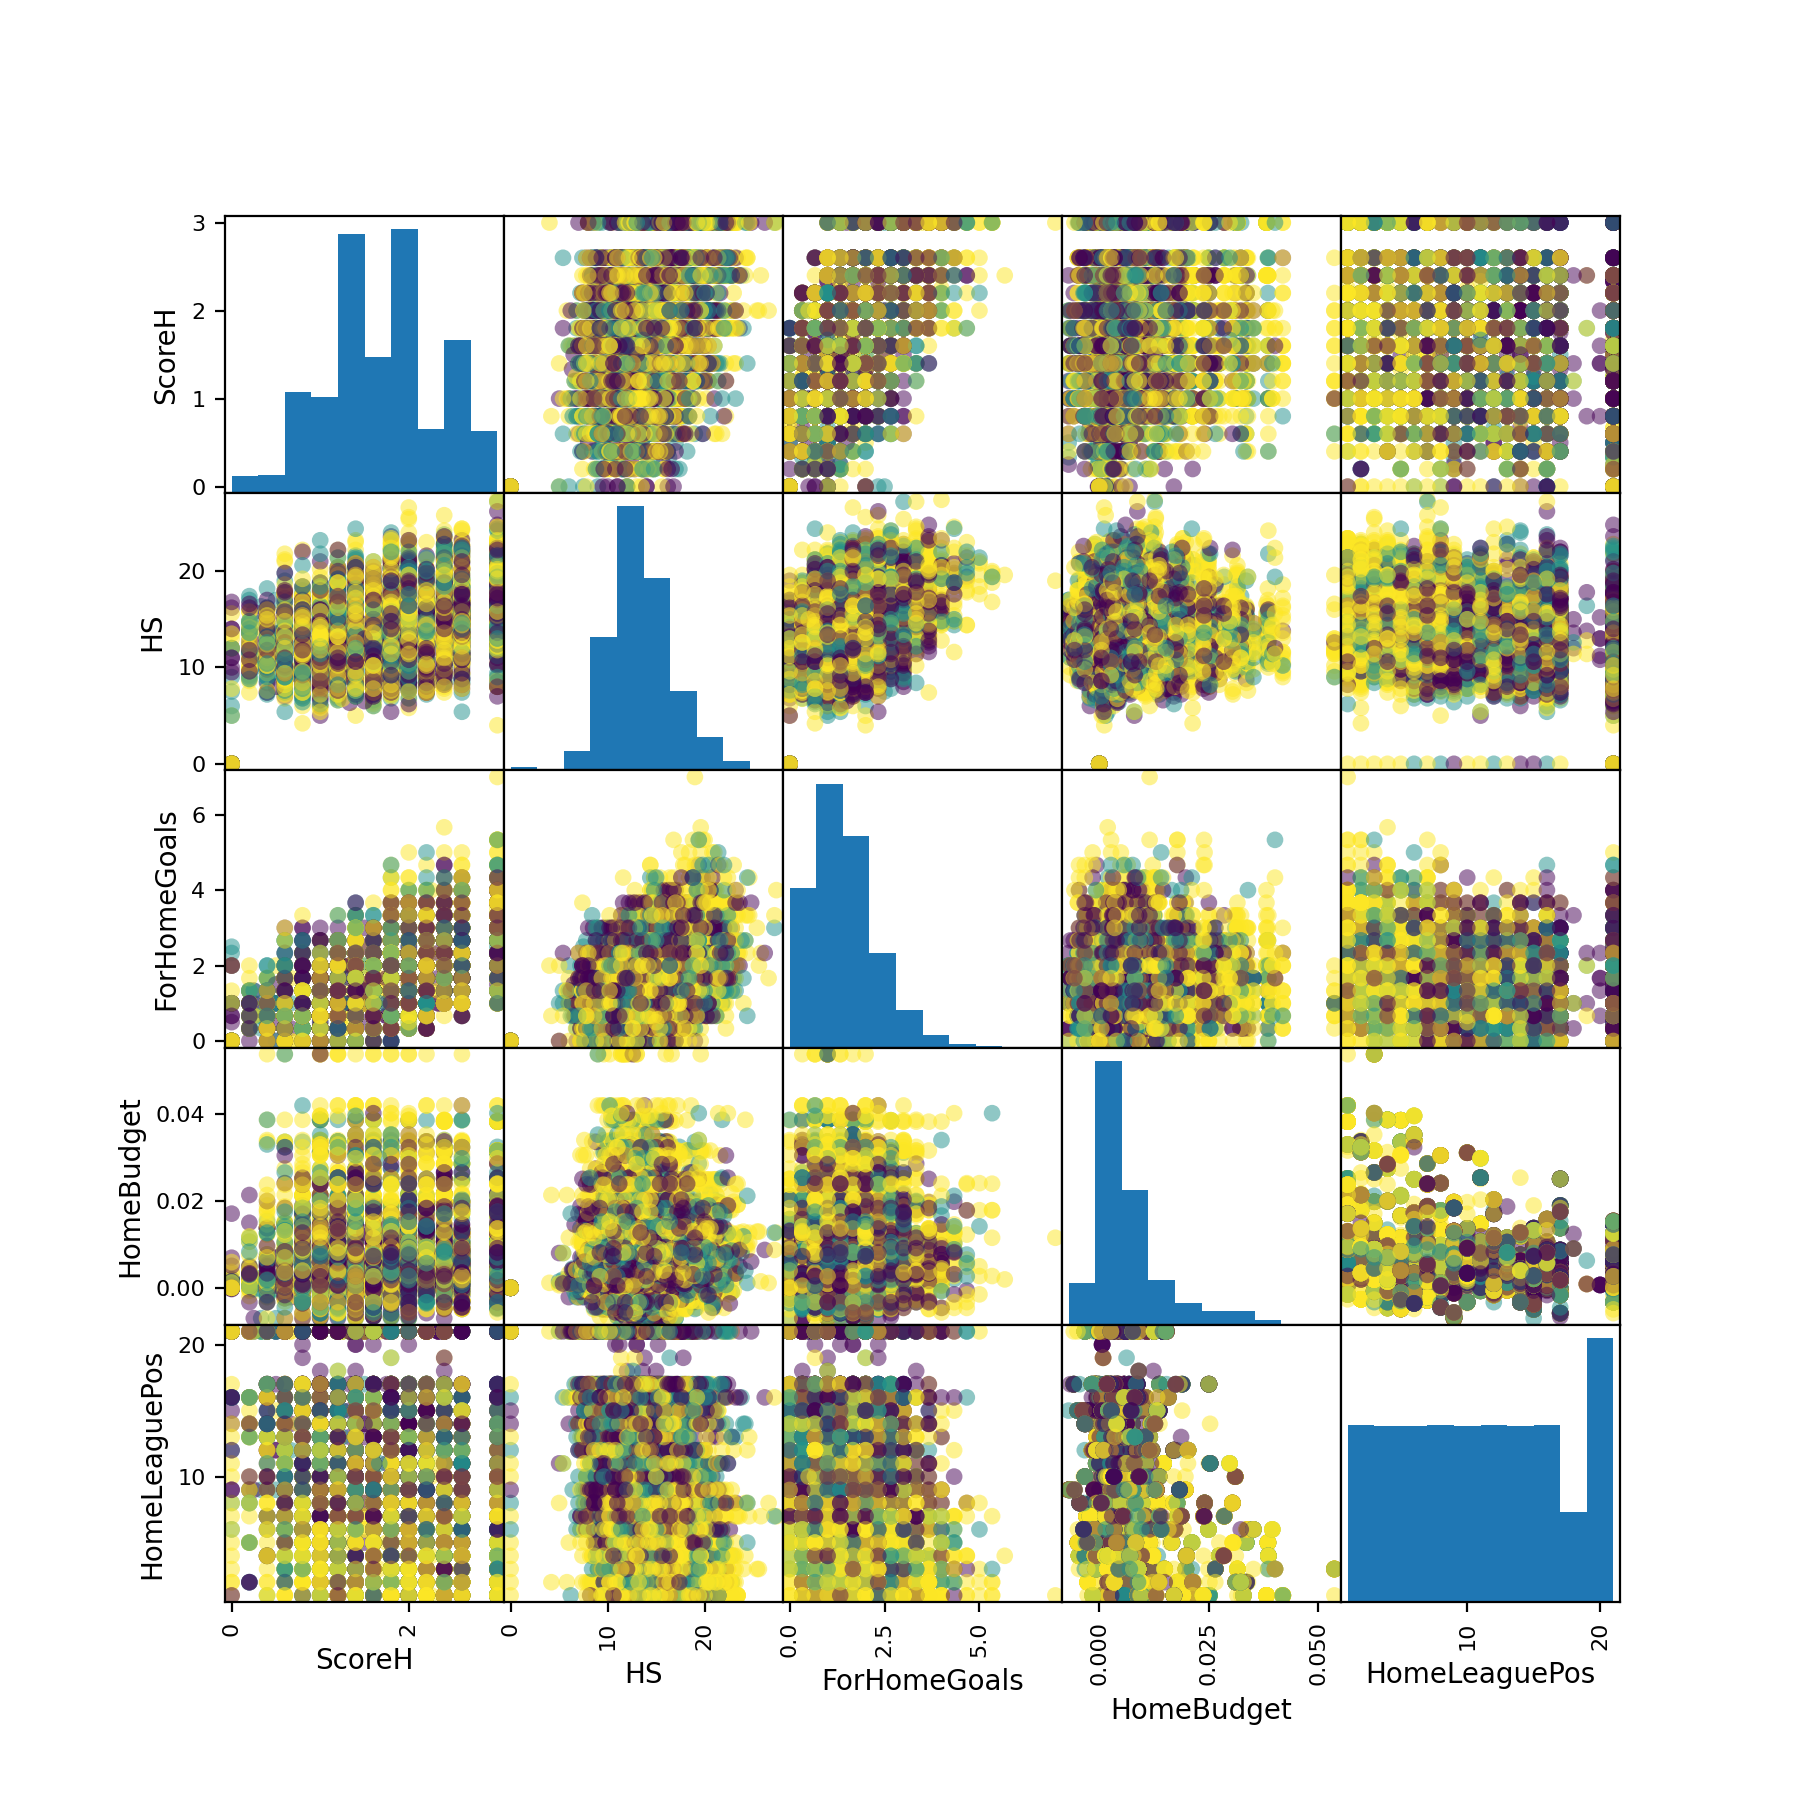

array([[<AxesSubplot: xlabel='ScoreH', ylabel='ScoreH'>,
        <AxesSubplot: xlabel='HS', ylabel='ScoreH'>,
        <AxesSubplot: xlabel='ForHomeGoals', ylabel='ScoreH'>,
        <AxesSubplot: xlabel='HomeBudget', ylabel='ScoreH'>,
        <AxesSubplot: xlabel='HomeLeaguePos', ylabel='ScoreH'>],
       [<AxesSubplot: xlabel='ScoreH', ylabel='HS'>,
        <AxesSubplot: xlabel='HS', ylabel='HS'>,
        <AxesSubplot: xlabel='ForHomeGoals', ylabel='HS'>,
        <AxesSubplot: xlabel='HomeBudget', ylabel='HS'>,
        <AxesSubplot: xlabel='HomeLeaguePos', ylabel='HS'>],
       [<AxesSubplot: xlabel='ScoreH', ylabel='ForHomeGoals'>,
        <AxesSubplot: xlabel='HS', ylabel='ForHomeGoals'>,
        <AxesSubplot: xlabel='ForHomeGoals', ylabel='ForHomeGoals'>,
        <AxesSubplot: xlabel='HomeBudget', ylabel='ForHomeGoals'>,
        <AxesSubplot: xlabel='HomeLeaguePos', ylabel='ForHomeGoals'>],
       [<AxesSubplot: xlabel='ScoreH', ylabel='HomeBudget'>,
        <AxesSubplot: xlabel='HS

In [16]:
pd.plotting.scatter_matrix(final[["ScoreH","HS","ForHomeGoals","HomeBudget","HomeLeaguePos"]], c = final["FTR"], marker = 'o', figsize=(9,9))

The correlation matrix of all the variables can be found, showing how much of a linear relationship each variable has with the full time result.

In [17]:
corr_matrix = final.corr()
corr_matrix["FTR"]

Day                 -0.024158
Month               -0.015832
Year                -0.038097
FTR                  1.000000
HomeLeaguePos       -0.241973
AwayLeaguePos        0.250923
HR                  -0.021207
HS                   0.100688
HST                  0.112081
ScoreH               0.079385
ForHomeGoals         0.069757
AgainstHomeGoals    -0.068222
ForHomeCorner        0.067958
AgainstHomeCorner   -0.060621
ForHomeFoul         -0.025020
AgainstHomeFoul     -0.060621
HomeBudget           0.128702
AR                   0.016134
AS                  -0.105669
AST                 -0.117066
ScoreA              -0.049695
ForAwayGoals        -0.090164
AgainstAwayGoals     0.058450
ForAwayCorner       -0.060563
AgainstAwayCorner    0.067954
ForAwayFoul         -0.060563
AgainstAwayFoul     -0.021251
AwayBudget          -0.152651
Name: FTR, dtype: float64

The mean correlation can be found, with the correlation of FTR with itself removed.

In [18]:
corr_matrix = corr_matrix.drop(["FTR"])
corr_matrix["FTR"].abs().mean()

0.08020004404800772

It can be seen that overall the each variable seems to be decently correlated (8.05%). To increase this average correlation, the dimensionality of the matrix can be reduced.

To do this, instead of having one column for the home goals and another for the away goals, this information can be compressed into one singular column with just the difference between the home and away goals.

### Reduction in Dimensionality

Combine this newly compressed data with the original data.

In [19]:
GoalsPredDifference = final["ForHomeGoals"]-final["ForAwayGoals"]
CornerPredDifference = final["ForHomeCorner"]-final["ForAwayCorner"]
FoulPredDifference = final["ForHomeFoul"]-final["ForAwayFoul"]
ScoreDiff = final["ScoreH"]-final["ScoreA"]
LeaguePosDiff = final["HomeLeaguePos"] - final["AwayLeaguePos"]
HSTP = (final["HST"]/final["HS"]*100).fillna(0)
ASTP = (final["AST"]/final["AS"]*100).fillna(0)

newdata = pd.DataFrame({"GoalsPredDifference":GoalsPredDifference,"CornerPredDifference":CornerPredDifference,"FoulPredDifference":FoulPredDifference,"ScoreDiff":ScoreDiff, "LeaguePosDiff": LeaguePosDiff ,"HSTP":HSTP,"ASTP":ASTP})
newdata = final[["FTR"]].join(newdata)

newdata

FTR  GoalsPredDifference  CornerPredDifference  FoulPredDifference  \
0       1             0.000000              0.000000            0.000000   
1       1             0.000000              0.000000            0.000000   
2      -1             0.000000              0.000000            0.000000   
3       0             0.000000              0.000000            0.000000   
4       1             0.000000              0.000000            0.000000   
...   ...                  ...                   ...                 ...   
8516   -1             2.000000             -4.000000           -5.333333   
8517   -1             1.000000              0.666667            6.666667   
8518    1            -0.333333             -1.000000            8.666667   
8519   -1            -1.333333             -0.333333            4.333333   
8520    0             0.666667              2.000000            5.333333   

      ScoreDiff  LeaguePosDiff       HSTP       ASTP  
0           0.0              0   0.000000   0.000000  
1           0.0             -4   0.000000   0.000000  
2           0.0              2   0.000000   0.000000  
3           0.0              1   0.000000   0.000000  
4           0.0            -10   0.000000   0.000000  
...         ...            ...        ...        ...  
8516        1.4             16  41.860465  33.802817  
8517        1.8             -6  32.926829  23.728814  
8518        1.0             -6  43.137255  25.000000  
8519        0.4            -10  32.051282  49.253731  
8520        1.0             18  43.902439  27.777778  

[8520 rows x 8 columns]

Repeat the visualisation and correlation metrics.

In [20]:
train = final[list(final)[1:7]].join(newdata[list(newdata)[1:]]).join(final[["HS","AS","HR","AR","HST","AST"]])
train = train.join(final[["HomeBudget","AwayBudget"]])
train = train.join(final[["HomeManager","AwayManager"]])
train

trainBeforeFC = train.copy()

trainBeforeFC[["Month","Year","HomeTeam", "AwayTeam", "LeaguePosDiff"]]

Month  Year       HomeTeam       AwayTeam  LeaguePosDiff
0         8     0       Charlton       Man City              0
1         8     0        Chelsea       West Ham             -4
2         8     0       Coventry  Middlesbrough              2
3         8     0          Derby    Southampton              1
4         8     0          Leeds        Everton            -10
...     ...   ...            ...            ...            ...
8516     12    22          Leeds       Man City             16
8517     12    22       West Ham      Brentford             -6
8518     12    22      Liverpool      Leicester             -6
8519      1    23      Tottenham    Aston Villa            -10
8520      1    23  Nott'm Forest        Chelsea             18

[8520 rows x 5 columns]

Whilst the data seems to still not be easily identifiable on individual points, we can see that there are clear gaussian distributions within the data.

<IPython.core.display.Javascript object>


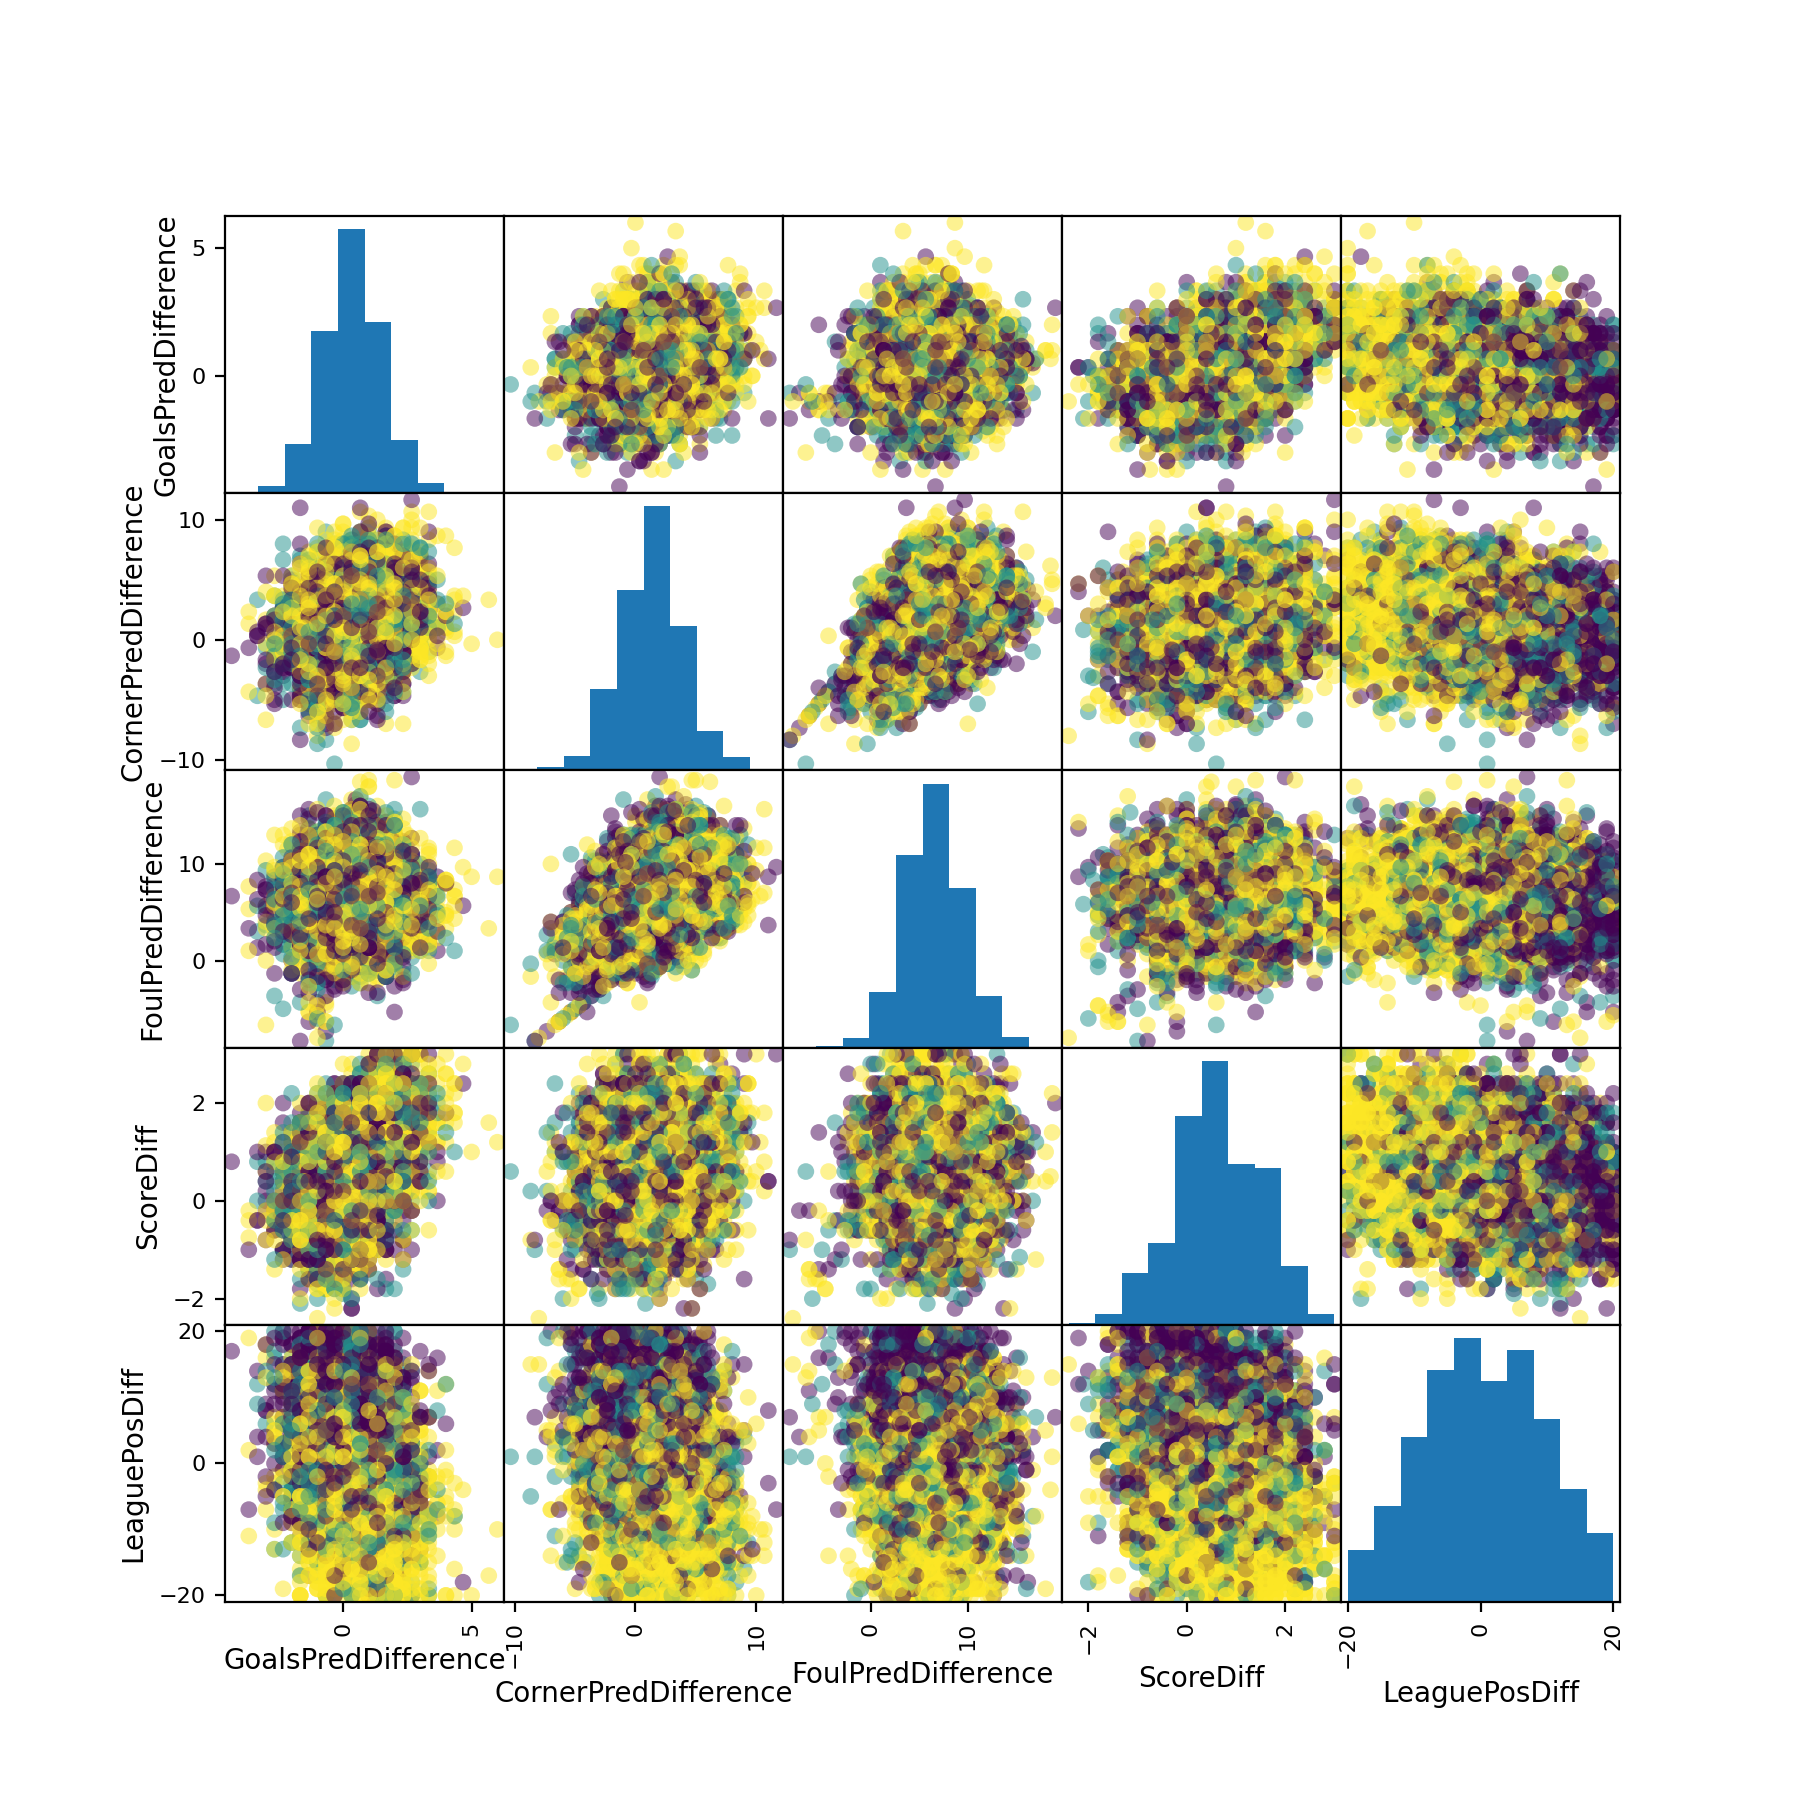

array([[<AxesSubplot: xlabel='GoalsPredDifference', ylabel='GoalsPredDifference'>,
        <AxesSubplot: xlabel='CornerPredDifference', ylabel='GoalsPredDifference'>,
        <AxesSubplot: xlabel='FoulPredDifference', ylabel='GoalsPredDifference'>,
        <AxesSubplot: xlabel='ScoreDiff', ylabel='GoalsPredDifference'>,
        <AxesSubplot: xlabel='LeaguePosDiff', ylabel='GoalsPredDifference'>],
       [<AxesSubplot: xlabel='GoalsPredDifference', ylabel='CornerPredDifference'>,
        <AxesSubplot: xlabel='CornerPredDifference', ylabel='CornerPredDifference'>,
        <AxesSubplot: xlabel='FoulPredDifference', ylabel='CornerPredDifference'>,
        <AxesSubplot: xlabel='ScoreDiff', ylabel='CornerPredDifference'>,
        <AxesSubplot: xlabel='LeaguePosDiff', ylabel='CornerPredDifference'>],
       [<AxesSubplot: xlabel='GoalsPredDifference', ylabel='FoulPredDifference'>,
        <AxesSubplot: xlabel='CornerPredDifference', ylabel='FoulPredDifference'>,
        <AxesSubplot: xlabel='

In [21]:
pd.plotting.scatter_matrix(train[["GoalsPredDifference","CornerPredDifference","FoulPredDifference","ScoreDiff", "LeaguePosDiff"]], c = train["FTR"], marker = 'o', figsize=(9,9))

In [22]:
corr_matrix = train.corr()
corr_matrix["FTR"]

Month                  -0.015832
Year                   -0.038097
FTR                     1.000000
GoalsPredDifference     0.111394
CornerPredDifference    0.092837
FoulPredDifference      0.013245
ScoreDiff               0.093083
LeaguePosDiff          -0.339620
HSTP                    0.040535
ASTP                   -0.049181
HS                      0.100688
AS                     -0.105669
HR                     -0.021207
AR                      0.016134
HST                     0.112081
AST                    -0.117066
HomeBudget              0.128702
AwayBudget             -0.152651
Name: FTR, dtype: float64

In [23]:
corr_matrix = corr_matrix.drop(["FTR"])
corr_matrix["FTR"].abs().mean()

0.09106006068173156

This reduction in dimensionality has improved the average correlation of all the variables (9.12%) according to the sklearn correlation matrix.

### One hot encoding

Another step to increase the usability of the data is to convert the non-numeric data into numeric data from strings. This can be done with One Hot encoders.

In [24]:
train["FTR"] = data["FTR"]
FTREnc = OneHotEncoder().fit([["H"],["A"],["D"]])
FTREncoded = FTREnc.transform(train['FTR'].to_numpy().reshape(-1, 1)).toarray()

refEnc = OneHotEncoder().fit(list(train["Referee"].drop_duplicates().to_numpy().reshape(-1, 1)))
refEncoded = refEnc.transform(list(train["Referee"].to_numpy().reshape(-1, 1))).toarray()[1]

managerEnc = OneHotEncoder().fit(list(train["HomeManager"].drop_duplicates().to_numpy().reshape(-1, 1)))
managerEncoded = managerEnc.transform(list(train["HomeManager"].to_numpy().reshape(-1, 1))).toarray()[1]

teamEnc = OneHotEncoder().fit(list(train["HomeTeam"].drop_duplicates().to_numpy().reshape(-1, 1)))
HTEncoded = teamEnc.transform(list(train["HomeTeam"].to_numpy().reshape(-1, 1))).toarray()[1]
ATEncoded = teamEnc.transform(list(train["AwayTeam"].to_numpy().reshape(-1, 1))).toarray()[1]

FTREncoded.shape

(8520, 3)

With the encoding dictionaries and ecoded data, the original values can be replaced with the new encoded data. However it is seen that the one hot encoded data of this magnitude can not be used since it spans more than 300 features compared to the original 5 features. This will need to be done another way.

### Feature conversion

One way to do this is to rank the attribute against the full time result and use that ranking as the converted data to link the strings to an integer.

First rank the home and away teams by the score, and divide by the total number of teams to normalise the data between 0 and 1.

In [25]:
teamCount = len(list(teams))

index = [i/(teamCount) for i in range(len(list(teams)))]
HomeData = pd.DataFrame(final.groupby(["HomeTeam"])["ScoreH"].mean()).sort_values("ScoreH")
AwayData  = pd.DataFrame(final.groupby(["AwayTeam"])["ScoreA"].mean()).sort_values("ScoreA")
HomeData.loc[:,"index"] = index
AwayData.loc[:,"index"] = index

HT = [ HomeData["index"][HomeData.axes[0]==team].values[0] for team in final["HomeTeam"] ] 
AT = [ AwayData["index"][AwayData.axes[0]==team].values[0] for team in final["AwayTeam"] ]

# Preview
HT[0:20]

[0.4888888888888889,
 0.9555555555555556,
 0.0,
 0.08888888888888889,
 0.6666666666666666,
 0.5555555555555556,
 0.8888888888888888,
 0.2222222222222222,
 0.8666666666666667,
 0.9777777777777777,
 0.9111111111111111,
 0.022222222222222223,
 0.5777777777777777,
 0.3111111111111111,
 0.8222222222222222,
 0.8444444444444444,
 0.7777777777777778,
 0.5111111111111111,
 0.6444444444444445,
 0.9111111111111111]

Do the same for the referee, home manager and away manager data. Normalising with respective to the total count of each attribute. The ranking is based on the full time result.

In [26]:
refCount = len(final["Referee"].drop_duplicates())

RefData = pd.DataFrame(final.groupby(["Referee"])["FTR"].sum()).sort_values("FTR")
RefData.loc[:,"index"] = [i/(refCount) for i in range(len(RefData))]
Ref = [RefData["index"][RefData.axes[0]==team].values[0] for team in final["Referee"] ]

managerCount = len(final["HomeManager"].drop_duplicates())

HomeManagerSorted = pd.DataFrame(final.groupby(["HomeManager"])["FTR"].sum()).sort_values("FTR")
HomeManagerSorted.loc[:,"index"] = [i/(managerCount) for i in range(len(HomeManagerSorted))]
HomeManagerConverted = [HomeManagerSorted["index"][HomeManagerSorted.axes[0]==team].values[0] for team in final["HomeManager"]]

AwayManagerSorted = pd.DataFrame(final.groupby(["AwayManager"])["FTR"].sum()).sort_values("FTR")
AwayManagerSorted.loc[:,"index"] = [i/(managerCount) for i in range(len(AwayManagerSorted))]
AwayManagerConverted = [AwayManagerSorted["index"][AwayManagerSorted.axes[0]==team].values[0] for team in final["AwayManager"]]

In [27]:
train["HomeTeam"] = HT
train["AwayTeam"] = AT
train["Referee"] = Ref
train["HomeManager"] = HomeManagerConverted
train["AwayManager"] = AwayManagerConverted
train["FTR"] = final["FTR"]

train[["HomeTeam", "AwayTeam", "Referee", "HomeManager", "AwayManager"]]

train

Month  Year  HomeTeam  AwayTeam   Referee  FTR  GoalsPredDifference  \
0         8     0  0.488889  0.844444  0.731429    1             0.000000   
1         8     0  0.955556  0.466667  0.011429    1             0.000000   
2         8     0  0.000000  0.777778  0.765714   -1             0.000000   
3         8     0  0.088889  0.511111  0.685714    0             0.000000   
4         8     0  0.666667  0.888889  0.788571    1             0.000000   
...     ...   ...       ...       ...       ...  ...                  ...   
8516     12    22  0.666667  0.844444  0.874286   -1             2.000000   
8517     12    22  0.644444  0.577778  0.560000   -1             1.000000   
8518     12    22  0.888889  0.644444  0.868571    1            -0.333333   
8519      1    23  0.866667  0.911111  0.177143   -1            -1.333333   
8520      1    23  0.444444  0.933333  0.742857    0             0.666667   

      CornerPredDifference  FoulPredDifference  ScoreDiff  ...    HS    AS  \
0                 0.000000            0.000000        0.0  ...   0.0   0.0   
1                 0.000000            0.000000        0.0  ...   0.0   0.0   
2                 0.000000            0.000000        0.0  ...   0.0   0.0   
3                 0.000000            0.000000        0.0  ...   0.0   0.0   
4                 0.000000            0.000000        0.0  ...   0.0   0.0   
...                    ...                 ...        ...  ...   ...   ...   
8516             -4.000000           -5.333333        1.4  ...  17.2  14.2   
8517              0.666667            6.666667        1.8  ...  16.4  11.8   
8518             -1.000000            8.666667        1.0  ...  10.2  14.4   
8519             -0.333333            4.333333        0.4  ...  15.6  13.4   
8520              2.000000            5.333333        1.0  ...  16.4  10.8   

            HR        AR  HST  AST  HomeBudget  AwayBudget  HomeManager  \
0     0.000000  0.000000  0.0  0.0    0.000000    0.000000     0.815217   
1     0.000000  0.000000  0.0  0.0    0.000000    0.000000     0.945652   
2     0.000000  0.000000  0.0  0.0    0.000000    0.000000     0.701087   
3     0.000000  0.000000  0.0  0.0    0.000000    0.000000     0.641304   
4     0.000000  0.000000  0.0  0.0    0.000000    0.000000     0.853261   
...        ...       ...  ...  ...         ...         ...          ...   
8516  0.333333  0.666667  7.2  4.8    0.017470    0.012965     0.244565   
8517  0.000000  0.333333  5.4  2.8    0.023918    0.008085     0.961957   
8518  0.000000  0.000000  4.4  3.6    0.013629    0.000473     0.972826   
8519  0.000000  0.000000  5.0  6.6    0.028419    0.012666     0.896739   
8520  0.000000  1.000000  7.2  3.0    0.015204    0.040027     0.467391   

      AwayManager  
0        0.309783  
1        0.978261  
2        0.809783  
3        0.826087  
4        0.782609  
...           ...  
8516     0.005435  
8517     0.385870  
8518     0.152174  
8519     0.146739  
8520     0.472826  

[8520 rows x 23 columns]

With all of the data now in numeric form, the data processing is complete and the correlation matrix can be recalculated to see how much the data has improved.

In [28]:
corr_matrix = train.corr()
corr_matrix["FTR"]

Month                  -0.015832
Year                   -0.038097
HomeTeam                0.225908
AwayTeam               -0.202913
Referee                 0.041588
FTR                     1.000000
GoalsPredDifference     0.111394
CornerPredDifference    0.092837
FoulPredDifference      0.013245
ScoreDiff               0.093083
LeaguePosDiff          -0.339620
HSTP                    0.040535
ASTP                   -0.049181
HS                      0.100688
AS                     -0.105669
HR                     -0.021207
AR                      0.016134
HST                     0.112081
AST                    -0.117066
HomeBudget              0.128702
AwayBudget             -0.152651
HomeManager             0.258153
AwayManager             0.235727
Name: FTR, dtype: float64

In [29]:
corr_matrix = corr_matrix.drop(["FTR"])
corr_matrix["FTR"].abs().mean()

0.11419591214593731

This has caused a large improvement with an average correlation of 11.42%. It can be seen that factors such as referee, time of year, and foul prediction have low correlation (less than 5%) but none of the factors have a correlation lower than 1% and thus none will be eliminated. The data is now ready for data seperation and the the various machine learning approaches.

### Data Separation

Now the latest attributes of each team in the test data is pulled in from the training data to give a sense of current form for the predictions. The order of the columns is modified to match the training data.

In [30]:
budgetsAndManagers = finalTestData.iloc[:,5:9]

finalTestData = finalTestData.iloc[:,:5]
finalTestData

finalTestData["GoalsPredDifference"] = 0.0
finalTestData["CornerPredDifference"] = 0.0
finalTestData["FoulPredDifference"] = 0.0
finalTestData["ScoreDiff"] = 0.0
finalTestData["LeaguePosDiff"] = 0.0
finalTestData["HSTP"] = 0.0
finalTestData["ASTP"] = 0.0
finalTestData["HS"] = 0.0
finalTestData["AS"] = 0.0
finalTestData["HR"] = 0.0
finalTestData["AR"] = 0.0
finalTestData["HST"] = 0.0
finalTestData["AST"] = 0.0


GoalsPredDifference = []
CornerPredDifference = []
FoulPredDifference = []
ScoreDiff = []
LeaguePosDiff = []
HSTP = []
ASTP = []
HS = []
AS = []
HR = []
AR = []
HST = []
AST = []

for i in range(len(finalTestData)):
    curr = trainBeforeFC.loc[trainBeforeFC['HomeTeam'] == finalTestData.iloc[i]["HomeTeam"]]
    curr = curr.iloc[-1]
    GoalsPredDifference.append(curr.loc["GoalsPredDifference"])
    CornerPredDifference.append(curr.loc["CornerPredDifference"])
    FoulPredDifference.append(curr.loc["FoulPredDifference"])
    ScoreDiff.append(curr.loc["ScoreDiff"])
    LeaguePosDiff.append(curr.loc["LeaguePosDiff"])
    HSTP.append(curr.loc["HSTP"])
    ASTP.append(curr.loc["ASTP"])
    HS.append(curr.loc["HS"])
    AS.append(curr.loc["AS"])
    HR.append(curr.loc["HR"])
    AR.append(curr.loc["AR"])
    HST.append(curr.loc["HST"])
    AST.append(curr.loc["AST"])
    
    
finalTestData["GoalsPredDifference"] = GoalsPredDifference
finalTestData["CornerPredDifference"] = CornerPredDifference
finalTestData["FoulPredDifference"] = FoulPredDifference
finalTestData["ScoreDiff"] = ScoreDiff
finalTestData["LeaguePosDiff"] = LeaguePosDiff
finalTestData["HSTP"] = HSTP
finalTestData["ASTP"] = ASTP
finalTestData["HS"] = HS
finalTestData["AS"] = AS
finalTestData["HR"] = HR
finalTestData["AR"] = AR
finalTestData["HST"] = HST
finalTestData["AST"] = AST

finalTestData = finalTestData.join(budgetsAndManagers)
finalTestData

Month  Year       HomeTeam        AwayTeam      Referee  \
0      1    23    Aston Villa           Leeds    J Gillett   
1      1    23      Brentford     Bournemouth    S Attwell   
2      1    23       Brighton       Liverpool     A Taylor   
3      1    23        Chelsea  Crystal Palace    P Tierney   
4      1    23        Everton     Southampton   A Marriner   
5      1    23     Man United        Man City  M Salisbury   
6      1    23      Newcastle          Fulham     S Hooper   
7      1    23  Nott'm Forest       Leicester     P Bankes   
8      1    23      Tottenham         Arsenal     J Brooks   
9      1    23         Wolves        West Ham      R Jones   

   GoalsPredDifference  CornerPredDifference  FoulPredDifference  ScoreDiff  \
0             0.333333              5.333333            6.666667       -0.4   
1             0.333333              3.000000            7.000000       -0.2   
2             0.666667              1.666667            9.333333        0.4   
3             2.000000              3.333333            8.333333        2.0   
4            -0.333333             -1.000000            6.333333        0.2   
5             2.000000              2.000000            7.333333        0.4   
6             1.000000              4.666667            5.666667        0.4   
7             0.666667              2.000000            5.333333        1.0   
8            -1.333333             -0.333333            4.333333        0.4   
9            -0.666667             -0.333333            5.000000        0.2   

   LeaguePosDiff  ...    HS    AS   HR        AR  HST  AST  HomeBudget  \
0             12  ...  13.4   9.0  0.0  0.000000  5.8  4.0    0.171153   
1              9  ...  17.6  13.0  0.0  0.333333  7.0  3.8    0.109252   
2             -5  ...  11.8  13.2  0.0  0.000000  3.8  6.8   -0.076411   
3            -18  ...  11.4   5.6  0.0  0.000000  5.2  1.2    0.540853   
4              6  ...   9.2  13.2  0.0  0.000000  3.2  4.6    0.109319   
5            -15  ...  14.2  11.2  0.0  0.000000  3.8  2.6    0.532599   
6              8  ...  14.8  14.4  0.0  0.000000  4.4  5.0    0.401139   
7             18  ...  16.4  10.8  0.0  1.000000  7.2  3.0    0.204948   
8            -10  ...  15.6  13.4  0.0  0.000000  5.0  6.6    0.383085   
9              5  ...  10.6  12.4  0.0  0.000000  3.0  4.8    0.122995   

   AwayBudget       HomeManager      AwayManager  
0    0.355541        Unai Emery      Jesse March  
1    0.053719      Thomas Frank      Gary O'Neil  
2    0.277379  Roberto De Zerbi     Jurgen Klopp  
3    0.233985     Graham Potter   Patrick Vieira  
4    0.148035     Frank Lampard     Nathan Jones  
5    0.264499      Erik Ten Hag    Pep Guardiola  
6    0.155265        Eddie Howe      Marco Silva  
7    0.009645      Steve Cooper  Brendan Rodgers  
8    0.621278     Antonio Conte     Mikel Arteta  
9    0.486782   Julen Lopetegui      David Moyes  

[10 rows x 22 columns]

The non-numeric values in the test data is converted to numeric using the same encoding as the training data.

In [31]:
RefTest = [RefData["index"][RefData.axes[0]==team].values[0] for team in finalTestData["Referee"] ]

finalTestData.loc[:,"Referee"] = RefTest

HTTest = [ HomeData["index"][HomeData.axes[0]==team].values[0] for team in finalTestData["HomeTeam"] ] 
ATTest = [ AwayData["index"][AwayData.axes[0]==team].values[0] for team in finalTestData["AwayTeam"] ]


finalTestData.loc[:,"HomeTeam"] = HTTest
finalTestData.loc[:,"AwayTeam"] = ATTest


HomeManagerConvertedTEST = [HomeManagerSorted["index"][HomeManagerSorted.axes[0]==team].values[0] for team in finalTestData["HomeManager"]]
AwayManagerConvertedTEST = [AwayManagerSorted["index"][AwayManagerSorted.axes[0]==team].values[0] for team in finalTestData["AwayManager"]]

finalTestData["HomeManager"] = HomeManagerConvertedTEST
finalTestData["AwayManager"] = AwayManagerConvertedTEST

finalTestData

Month  Year  HomeTeam  AwayTeam   Referee  GoalsPredDifference  \
0      1    23  0.244444  0.422222  0.040000             0.333333   
1      1    23  0.711111  0.200000  0.874286             0.333333   
2      1    23  0.800000  0.822222  0.925714             0.666667   
3      1    23  0.955556  0.622222  0.748571             2.000000   
4      1    23  0.822222  0.511111  0.942857            -0.333333   
5      1    23  0.977778  0.844444  0.662857             2.000000   
6      1    23  0.777778  0.866667  0.782857             1.000000   
7      1    23  0.444444  0.644444  0.742857             0.666667   
8      1    23  0.866667  0.955556  0.177143            -1.333333   
9      1    23  0.422222  0.466667  0.125714            -0.666667   

   CornerPredDifference  FoulPredDifference  ScoreDiff  LeaguePosDiff  ...  \
0              5.333333            6.666667       -0.4             12  ...   
1              3.000000            7.000000       -0.2              9  ...   
2              1.666667            9.333333        0.4             -5  ...   
3              3.333333            8.333333        2.0            -18  ...   
4             -1.000000            6.333333        0.2              6  ...   
5              2.000000            7.333333        0.4            -15  ...   
6              4.666667            5.666667        0.4              8  ...   
7              2.000000            5.333333        1.0             18  ...   
8             -0.333333            4.333333        0.4            -10  ...   
9             -0.333333            5.000000        0.2              5  ...   

     HS    AS   HR        AR  HST  AST  HomeBudget  AwayBudget  HomeManager  \
0  13.4   9.0  0.0  0.000000  5.8  4.0    0.171153    0.355541     0.820652   
1  17.6  13.0  0.0  0.333333  7.0  3.8    0.109252    0.053719     0.483696   
2  11.8  13.2  0.0  0.000000  3.8  6.8   -0.076411    0.277379     0.489130   
3  11.4   5.6  0.0  0.000000  5.2  1.2    0.540853    0.233985     0.108696   
4   9.2  13.2  0.0  0.000000  3.2  4.6    0.109319    0.148035     0.804348   
5  14.2  11.2  0.0  0.000000  3.8  2.6    0.532599    0.264499     0.646739   
6  14.8  14.4  0.0  0.000000  4.4  5.0    0.401139    0.155265     0.793478   
7  16.4  10.8  0.0  1.000000  7.2  3.0    0.204948    0.009645     0.467391   
8  15.6  13.4  0.0  0.000000  5.0  6.6    0.383085    0.621278     0.896739   
9  10.6  12.4  0.0  0.000000  3.0  4.8    0.122995    0.486782     0.260870   

   AwayManager  
0     0.239130  
1     0.391304  
2     0.016304  
3     0.494565  
4     0.179348  
5     0.005435  
6     0.858696  
7     0.152174  
8     0.076087  
9     0.967391  

[10 rows x 22 columns]

Now the data will be separated into testing data and training data, ensuring that data is accurately represented in both fields, avoiding data imbalance. To do this, stratify based on the home team will be used since there should be enough data to ensure that the full time result class is correctly balanced but the number of matches in which teams took part is not balanced from the start. This will lead to a dataset where there is an equal partition of the home team data between teh two data sets.

In [32]:
train = train[:8486]

X_train, X_test = train_test_split(train,test_size = 0.2,random_state = 44,stratify = train["FTR"])
X_train , y_train = X_train.drop("FTR",axis = 1) , X_train["FTR"].copy()
X_test , y_test = X_test.drop("FTR",axis = 1) , X_test["FTR"].copy()

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

## 4. Methodology Overview

Hyper parameter optimisation is carried out with k-fold cross validation on various machine learning algorithms such as logistical regression, k nearest neighbour, support vector machines, decision trees and random forests.

## 5. Model Training & Validation

### Hyperparameter Optimisation

**NOTE**: The following cells carry out hyperparameter optimisation of the various algorithms. This takes a while and so in order to replicate the same algorithms used in the study skip the folling cells. There is a cell below that uses the best found parameters and trains each model once.

In [33]:
from sklearn.linear_model import LogisticRegression
import warnings

#warnings.filterwarnings('ignore')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    print("Starting Hyper Param Optimisation for LR. I might take a while.")
    
    hyperparameters = dict(penalty=["l2"],
                           C=np.logspace(-0.5,-0.3,8),
                           solver=['liblinear'],
                          class_weight=[None],random_state=[34,42]
                          )

    k = 10
    lr = GridSearchCV(estimator=LogisticRegression(),
                       param_grid=hyperparameters,
                       scoring='accuracy',
                       cv=k)
    lr.fit(X_train, y_train)    
    y_lr = lr.predict(X_test)
    
    print("Tuned Hyperparameters :", lr.best_params_)
    print("Accuracy :",accuracy_score(y_lr, y_test))
    

Starting Hyper Param Optimisation for LR. I might take a while.
Tuned Hyperparameters : {'C': 0.31622776601683794, 'class_weight': None, 'penalty': 'l2', 'random_state': 34, 'solver': 'liblinear'}
Accuracy : 0.5412249705535924


In [34]:
from sklearn.neighbors import KNeighborsClassifier
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    print("Starting Hyper Param Optimisation for KNN. I might take a while.")
    
    #List Hyperparameters that we want to tune.
    leaf_size = [1]
    n_neighbors = np.linspace(80.0, 100.0, num=10, dtype=int)
    p=[1]
    #Convert to dictionary
    hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
    
    
    k = 10
    knn = GridSearchCV(estimator=KNeighborsClassifier(),
                       param_grid=hyperparameters,
                       cv=k)
    knn.fit(X_train, y_train)
    y_knn = knn.predict(X_test)
    
    print("Tuned Hyperparameters :", knn.best_params_)
    print("Accuracy :",knn.best_score_)
    

Starting Hyper Param Optimisation for KNN. I might take a while.
Tuned Hyperparameters : {'leaf_size': 1, 'n_neighbors': 86, 'p': 1}
Accuracy : 0.5310855370338995


In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    
    print("Starting Hyper Param Optimisation for PolySVM. I might take a while.")
    
    hyperparameters = dict(C=np.logspace(-0.3,-0.1,5),
                           degree=[3])

    k = 5

    svm_poly = GridSearchCV(estimator=SVC(kernel='poly'),
                            param_grid=hyperparameters,
                            cv=k)
    svm_poly.fit(X_train, y_train)
    y_svm_poly = svm_poly.predict(X_test)
    
    print("Tuned Hyperparameters :", svm_poly.best_params_)
    print("Accuracy :",svm_poly.best_score_)

Starting Hyper Param Optimisation for PolySVM. I might take a while.


KeyboardInterrupt: 

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

DTC_2 = DecisionTreeClassifier(random_state=10, criterion="entropy", max_depth=4)
DTC_2.fit(X_train,y_train)# predict the labels on validation dataset
predictions_DTC_2 = DTC_2.predict(X_test)# Use accuracy_score function to get the accuracy
print("DTC Accuracy Score -> ",accuracy_score(predictions_DTC_2, y_test)*100)

fig = plt.figure(figsize=(10,10),dpi = 300)
_ = tree.plot_tree(DTC_2, feature_names=list(X_train),class_names = ["home","Draw","Away"], filled=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    k =3
    
    print("Starting Hyper Param Optimisation for Random Forest. I might take a while.")
    
    RF_clf = GridSearchCV(RandomForestClassifier(),param_grid={'n_estimators': [400,330,350],
                                                               "random_state":[22],
                                                               "class_weight" : ["balanced_subsample",None]},
                cv=k).fit(X_train,y_train)
    y_pred_clf=RF_clf.predict(X_test)
    
    print("Accuracy:",accuracy_score(y_test, y_pred_clf))
    print("Number of Draws Predicted: ", sum(y_pred_clf == 0))
    print("Tuned Hyperparameters :", RF_clf.best_params_)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    
    print("Starting Hyper Param Optimisation for SVM RBF. I might take a while.")
    
    k=5

    svm_rbf = GridSearchCV(estimator=SVC(kernel='rbf'),
                           param_grid={"C":[0.89,0.9,0.91],
                                       'gamma': [0.0011,0.0013],
                                       "random_state":[42]},
                           cv=k)
    svm_rbf.fit(X_train, y_train)
    y_svm_rbf = svm_rbf.predict(X_test)
    
    
    
    print("Tuned Hyperparameters :", svm_rbf.best_params_)
    print("Accuracy :",accuracy_score(y_svm_rbf,y_test))

### Finalised models

**NOTE**: The following cell replicates all of the best found hyperparameter combinations without having to do the optimisation.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


lr = LogisticRegression(C = 0.31622776601683794,
                              class_weight = None,
                              penalty = 'l2',
                              solver = 'liblinear',
                              random_state=34).fit(X_train, y_train)
y_lr = lr.predict(X_test)

knn = KNeighborsClassifier(leaf_size = 1,
                              n_neighbors = 88,
                              p = 1,).fit(X_train, y_train)
y_knn = knn.predict(X_test)



svm_poly =SVC(kernel='poly',
              C=0.5623413251903491,
              degree=3
             ).fit(X_train, y_train)
y_svm_poly = svm_poly.predict(X_test)


svm_rbf =SVC(kernel='rbf',
              C=0.91,
              gamma=0.0011,
              probability=True,
              random_state=42
             ).fit(X_train, y_train)
y_svm_rbf = svm_rbf.predict(X_test)


RF_clf = RandomForestClassifier(class_weight = None,
                              n_estimators = 400,
                              random_state=22).fit(X_train, y_train)
y_pred_clf = RF_clf.predict(X_test)

In [37]:
for model, prediction in zip(['logistic regression', 'knn', 
                              'polynomial svm', 'rbf svm',"random forest"],
                             [y_lr, y_knn, y_svm_poly, y_svm_rbf,y_pred_clf]):
    print('%s: %.4f' % (model, accuracy_score(y_test, prediction)))

logistic regression: 0.5412
knn: 0.5312
polynomial svm: 0.5283
rbf svm: 0.5342
random forest: 0.5342


## 6. Results

In [38]:
from sklearn.metrics import classification_report

print("Evaluation: Random Forest ")
print(classification_report(y_test,y_pred_clf))

print("Evaluation: Poly kernel")
print(classification_report(y_test,y_svm_poly))

print("Evaluation: RBF kernel")
print(classification_report(y_test,y_svm_rbf))

print("Evaluation: Logistic Regression")
print(classification_report(y_test,y_lr))

Evaluation: Random Forest 
              precision    recall  f1-score   support

          -1       0.51      0.48      0.49       494
           0       0.35      0.07      0.12       424
           1       0.56      0.82      0.66       780

    accuracy                           0.53      1698
   macro avg       0.47      0.46      0.43      1698
weighted avg       0.49      0.53      0.48      1698

Evaluation: Poly kernel
              precision    recall  f1-score   support

          -1       0.55      0.42      0.48       494
           0       0.23      0.03      0.05       424
           1       0.53      0.87      0.66       780

    accuracy                           0.53      1698
   macro avg       0.44      0.44      0.40      1698
weighted avg       0.46      0.53      0.46      1698

Evaluation: RBF kernel
              precision    recall  f1-score   support

          -1       0.50      0.50      0.50       494
           0       0.00      0.00      0.00       424
 

Since the random forest is able to predict draws, while the polynomial rbf doesnt, the draws predicted will be taken by the random forest and the home/away wins will be predicted by the polynomial SVM.

In [39]:
combined = []
for i in range(len(y_test)):
        combined.append(y_svm_rbf[i]*pd.Series(y_pred_clf).abs()[i])
print("Evaluation: Combined Forest and Poly Kernel")
print("Accuracy :", accuracy_score(y_test, combined))
print(classification_report(y_test,combined))

Evaluation: Combined Forest and Poly Kernel
Accuracy : 0.5371024734982333
              precision    recall  f1-score   support

          -1       0.52      0.48      0.50       494
           0       0.35      0.07      0.12       424
           1       0.56      0.83      0.67       780

    accuracy                           0.54      1698
   macro avg       0.48      0.46      0.43      1698
weighted avg       0.49      0.54      0.48      1698



Generating a voting classifier was investigated next.

In [40]:
 #warnings.filterwarnings('ignore')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    print("Starting Hyper Param Optimisation for LR. I might take a while.")

    hyperparameters = dict(penalty=["l2","l1"],
                           C=np.logspace(-0.5,-0.3,8),
                           solver=['liblinear',"lbfgs"],
                          class_weight=["balanced"],random_state=[34,42]
                          )

    k = 10
    lr_bal = GridSearchCV(estimator=LogisticRegression(),
                       param_grid=hyperparameters,
                       scoring='accuracy',
                       cv=k)
    lr_bal.fit(X_train, y_train)
    y_lr_bal = lr.predict(X_test)

Starting Hyper Param Optimisation for LR. I might take a while.


KeyboardInterrupt: 

In [41]:
lr_bal = LogisticRegression(C = 0.46927624593488376,
                              class_weight = "balanced",
                              penalty = 'l2',
                              solver = 'liblinear',
                              random_state=34).fit(X_train, y_train)
y_lr_bal = lr_bal.predict(X_test)

**NOTE:** The following works if the hyperparameter optimsation is carried out, if not use the cell below.

In [ ]:
lr_best = lr.best_estimator_
lr_bal_best = lr_bal.best_estimator_
RF_clf_best = RF_clf.best_estimator_ 

**NOTE:** Use this cell if hyperparameter optimisation was not used.

In [42]:
lr_best = lr
lr_bal_best = lr_bal
RF_clf_best = RF_clf

In [43]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[("lr",lr_best),("lr_bal",lr_bal_best),("RF",RF_clf_best)],voting = "soft")
voting.fit(X_train,y_train)
y_voting = voting.predict(X_test)
accuracy_score(y_test, y_voting) 

0.5465253239104829

In [45]:
print("Evaluation: Voting estimator")
print("Accuracy :", accuracy_score(y_test, y_voting))
print(classification_report(y_test,y_voting))

Evaluation: Voting estimator
Accuracy : 0.5465253239104829
              precision    recall  f1-score   support

          -1       0.50      0.57      0.53       494
           0       0.39      0.04      0.06       424
           1       0.58      0.81      0.67       780

    accuracy                           0.55      1698
   macro avg       0.49      0.47      0.42      1698
weighted avg       0.51      0.55      0.48      1698



<IPython.core.display.Javascript object>


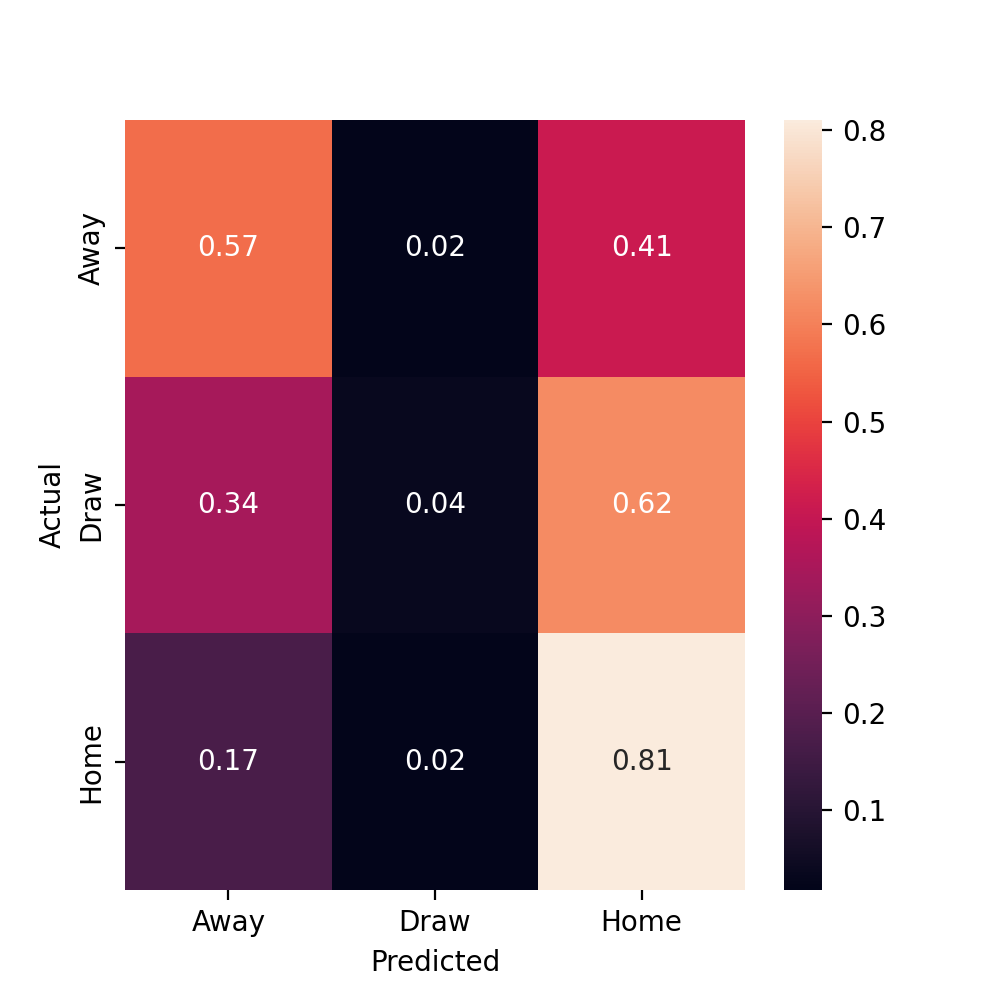

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test,y_voting)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["Away","Draw","Home"], yticklabels=["Away","Draw","Home"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

Being the best performing clasifier, the voting algorithm is the main algorithm.

### The Low-Draw Conundrum

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test,y_svm_rbf)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["Away","Draw","Home"], yticklabels=["Away","Draw","Home"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

There seems to be a low amount (and even none) of draws that were predicted by some of our algorithms. It was initially thought that since there was a low number of draws compared to other results the algorithms were simply ignoring them. This is why the next steps were attempts at more balanced methods of distribution to see if the scores would be impacted.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
for i in range(0,9):

    print(3 + 4*i)
    DTC_Draw = DecisionTreeClassifier(random_state=40,
                                      criterion="entropy",
                                      max_depth=3 + 4*i, 
                                      class_weight="balanced")
    DTC_Draw.fit(X_train,y_train.abs())# predict the labels on validation dataset
    predictions_DTC_Draw = DTC_Draw.predict(X_test)# Use accuracy_score function to get the accuracy
    print("Accuracy Score -> ",accuracy_score(predictions_DTC_Draw, y_test.abs())*100)
    
print("Number of Draws Predicted: ", sum(predictions_DTC_Draw == 0))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.abs(),predictions_DTC_Draw)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["Draw","Not Draw"], yticklabels=["Draw","Not Draw"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

It is seen that there is a sharp drop in performance when the coefficients are balanced. The next step is to investigatee if the problem originates from the data not being ranked on Draws, but instead being ranked on Home wins.

In [ ]:
def DrawDataGenerator(NameVar,DataSource,Rename):
    Count = len(final[NameVar].drop_duplicates())
    RefData = pd.DataFrame(DataSource.groupby([NameVar])["FTR"].sum()).sort_values("FTR")
    RefData.loc[:,"index"] = [i/(Count) for i in range(len(RefData))]
    
    refDraws =pd.DataFrame(DataSource.groupby([NameVar])["FTR"].apply(lambda c: c.abs().mean()))

    # Making sure that things with a low match count doesn't produce bias by replacing the datapoint with the average of the dataset

    RD = []
    for i in range(len(refDraws)):
        if DataSource.groupby([NameVar])["FTR"].count()[i] < 5:
            RD.append(refDraws.mean()["FTR"])
        else:
             RD.append(refDraws["FTR"].values[i])
    Ref = pd.DataFrame([RefData[RefData.axes[0]==team].values[0][1] for team in final[NameVar] ])

    return(Ref.rename(columns={0:Rename}))

In [ ]:
RefDraw = DrawDataGenerator("Referee",final,"RefDraw")
HTDraw = DrawDataGenerator("HomeTeam",final,"HTDraw")
ATDraw = DrawDataGenerator("AwayTeam",final,"ATDraw")
DrawData = (HTDraw.join(ATDraw)).join(RefDraw)


In [ ]:
Dtrain = train.join(DrawData).shift(periods=1, fill_value=0)

In [ ]:
DX_train, DX_test = train_test_split(Dtrain,test_size = 0.2,random_state = 44,stratify = Dtrain["FTR"])
DX_train , Dy_train = DX_train.drop("FTR",axis = 1) , DX_train["FTR"].copy()
DX_test , Dy_test = DX_test.drop("FTR",axis = 1) , DX_test["FTR"].copy()
DX_train.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=300,random_state = 23,class_weight = "balanced_subsample")
clf.fit(DX_train,Dy_train)
Dy_pred=clf.predict(DX_test)
print("Evaluation: Draw Random Forest")
print("Accuracy:",accuracy_score(Dy_test, Dy_pred))
print("Number of Draws Predicted: ", sum(Dy_pred == 0))
print(classification_report(Dy_test,Dy_pred))

It can be seen that the new data does not increase the accuracy of the predictions. Thus there might be missing features or more the more probable scenario, draws are extremely complex to predict.

The voting classifier will still be used as the final algorithm.

## 7. Final Prediction on Test Set

Predicting the final results of the test data using voting classifier.

In [44]:
y_pred_test_final = voting.predict(finalTestData)
y_pred_test_final

array([-1,  0, -1,  0, -1,  0, -1, -1, -1, -1])

Export final predictions as csv.

In [65]:
exportTestCSV = pd.read_csv('epl-test.csv')
exportTestCSV = exportTestCSV.drop(columns=["Day","Month","Year", "Referee"])

exportPredictions = []

for i in range(len(y_pred_test_final)):
    result = y_pred_test_final[i]
    
    if result == 1:
        exportPredictions.append('H')
    elif result == -1:
        exportPredictions.append('A')
    elif result == 0:
        exportPredictions.append('D')
    
    

exportTestCSV["FTR"] = exportPredictions

compression_opts = dict(method='zip',
                        archive_name='GroupF_Submission.csv')  
exportTestCSV.to_csv('out.zip', index=False, compression=compression_opts)  

exportTestCSV

date       HomeTeam        AwayTeam FTR
0  14/01/2023    Aston Villa           Leeds   A
1  14/01/2023      Brentford     Bournemouth   D
2  14/01/2023       Brighton       Liverpool   A
3  14/01/2023        Chelsea  Crystal Palace   D
4  14/01/2023        Everton     Southampton   A
5  14/01/2023     Man United        Man City   D
6  14/01/2023      Newcastle          Fulham   A
7  14/01/2023  Nott'm Forest       Leicester   A
8  14/01/2023      Tottenham         Arsenal   A
9  14/01/2023         Wolves        West Ham   A